# Project 3: Natural Language Processing of Subreddit Posts

### Contents:

- [Modelling](#Modelling)
- [Feature Importance](#Feature-Importance)
- [Misclassification Analysis](#Misclassification-Analysis)
- [Conclusions & Recommendations](#Conclusions-&-Recommendations)

### Import Libraries

In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# Import time- and API- related libraries
import time, requests
from datetime import datetime
import json

# Import warnings to remove flags when project is complete
import warnings
warnings.filterwarnings('ignore')

#import pre-processing libraries for cleaning the data
import string
import re
import nltk
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

pd.set_option('display.max_colwidth', 100)

# Import modelling-related libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, accuracy_score, plot_roc_curve, roc_auc_score, f1_score

In [2]:
# read the dataset 
combined_df2 = pd.read_csv('../project_3/data/combined_df2.csv')

## Modelling

### Create Train Test Sets

In [3]:
# train_test_split
X = combined_df2['all_text']
y = combined_df2['subreddit']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 42,
                                                    stratify = y)

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1469,)
(1469,)
(630,)
(630,)


### Baseline Model

In [19]:
#Baseline model

combined_df2['subreddit'].value_counts(normalize=True)

# the classes are balanced, each are 50%

1    0.500238
0    0.499762
Name: subreddit, dtype: float64

We use the higher probability of 'subreddit' as the baseline. However, we note that both subreddits have equal probability. Obtaining the probability distribution, we find that given a random text, choosing 'investing' as the subreddit gives us a 50% chance of being correct. Hence, our baseline model is 50%.

### Create performance tracking table

Here, we create a table to track the performance of various models as we attempt to find better models or feature engineering to improve our performance. 

Below are the definitions of the performance metrics:

- Accuracy: totoal correct predictions divided by all predictions
- Sensitivity: true positive rate (correct positive predictions divided by total positives)
- Specificity: true negative rate (correct negative predictions divided by total negatives)
- Precision: positive predictive value (correct positive predictions divided by all positive predictions)
- Misclassification: totoal incorrect predictions dividided by all predictions
    

In [20]:
# Create empty results dataframe
df_results = pd.DataFrame(
    columns = [
        'Model No.',
        'Word Vectorizer',
        'Classifier',
        'CV Score (train)',
        'Accuracy (train)',
        'Accuracy (test)',
        'Sensitivity (test)',
        'Specificity (test)',
        'Precision (test)',
        'Misclassification (test)',
        'Runtime (sec)',
#         'Best Parameters',
        'Remarks'
    ]
)

In [21]:
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Misclassification (test),Runtime (sec),Remarks


### Create custom function

Below is a custom function that automates a few steps:
- Instantiate a GridSearchCV
- Fit on train set
- Create confusion matrix on test set
- Print results of best parameters, best score, train score, test score and various confusion matrix metrics

In [22]:
# Create function to run pipe and print results
def run_grid(X_train, X_test, y_train, y_test):
    
    # Start 'stopwatch' to measure runtime
    tic = time.time()
    
    # Instantiate GridSearchCV
    gs = GridSearchCV(
        pipe, 
        param_grid = params, 
        n_jobs = -1, 
        cv = 5,
        verbose = 1
    )

    # Fit model
    gs.fit(X_train, y_train)

    # Confusion matrix
    y_pred = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # End 'stopwatch' 
    toc = time.time()
    time_taken = toc - tic 
    
    # Find current length of df_results
    length = len(df_results)
    
    # Store results in new_row
    new_row = [{
        'Model No.' : length + 1,
        'Word Vectorizer' : pipe.steps[0][1],
        'Classifier' : pipe.steps[1][1],
        'CV Score (train)' : round(gs.best_score_, 3),
        'Accuracy (train)': round(gs.score(X_train, y_train), 3),
        'Accuracy (test)' : round(gs.score(X_test, y_test) ,3 ),
        'Sensitivity (test)' : round (tp/(tp+fn), 3),
        'Specificity (test)' : round (tn/(tn+fp), 3),
        'Precision (test)' : round (tp/(tp+fp), 3),
        'Misclassification (test)' : round (1-(tp+tn)/(tn+fp+fn+tp),3),
        'Runtime (sec)' : round(time_taken),
#         'Best Parameters' : gs.best_params_
    }]
    
    # Print best parameters from GridSearchCV
    print('Best Parameters:', gs.best_params_)
    
    return new_row

### Parametric model: Logistic Regression



**CountVectorizer / Logistic**

In [23]:
%%time

cvec = CountVectorizer()
logit = LogisticRegression()

# Make pipe
pipe = Pipeline([
    ('cvec', cvec),
    ('logit', logit)])

# Set parameters
params = {
    'cvec__max_features' : [1000, 2000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'logit__C': [0.1, 1, 10],
    'logit__penalty': ['l2'],
    }

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'cvec__max_features': 2000, 'cvec__ngram_range': (1, 1), 'logit__C': 0.1, 'logit__penalty': 'l2'}
CPU times: user 867 ms, sys: 163 ms, total: 1.03 s
Wall time: 15.8 s


In [24]:
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Misclassification (test),Runtime (sec),Remarks
0,1,CountVectorizer(),LogisticRegression(),0.902,0.993,0.916,0.933,0.898,0.902,0.084,16,NaN


Logistic model suffers from a severe case of overfitting as its train score is much higher than test (0.993 vs 0.916). Let's try out TD-IDF vectorizer on logit model

**TfidfVectorizer / Logistic**

In [25]:
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logit', LogisticRegression())
])

# Set parameters
params = {
    'tvec__max_features' : [1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'logit__C': [0.1, 1, 10],
    'logit__penalty': ['l2'],
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'logit__C': 10, 'logit__penalty': 'l2', 'tvec__max_features': 2000, 'tvec__ngram_range': (1, 1)}


,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Misclassification (test),Runtime (sec),Remarks
0,1,CountVectorizer(),LogisticRegression(),0.902,0.993,0.916,0.933,0.898,0.902,0.084,16,NaN
0,2,TfidfVectorizer(),LogisticRegression(),0.917,0.997,0.944,0.949,0.940,0.940,0.056,14,NaN


Logit model with TF-IDF vectorizer performs slightly better than the Count vectorizer. The mean cross validation score is higher than the Count Vectorizer, and the train score is slightly higher than test (0.997 vs 0.944).

**Comparing Logistic Regression Results**

1. Overall, we find that a logistic regression gives us a great results on the following metrics: Accuracy, Sensitivity, Specificity, Precision and Misclassification.
2. Based on our results, a TF-IDF vectorizer had scored better for all of our metrics.
3. The TF-IDF vectorizer has a relatively lower Misclassification Rate as compared to Count Vectorizer.

Based on our findings, a TF-IDF vectorized logistic regression model performs better than a Count Vectorized logistic regression model.

Conclusion: Better Vectorizer: TVEC

### Parametric model: MultiNomial Naive Bayes



**CountVectorizer / Multinomial**

In [27]:
# Make pipe
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# Set parameters
params = {
    'cvec__max_features' : [1000, 2000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': [.25, .5, 1],
    'nb__fit_prior': [True, False]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'cvec__max_features': 2000, 'cvec__ngram_range': (1, 2), 'nb__alpha': 0.25, 'nb__fit_prior': True}


,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Misclassification (test),Runtime (sec),Remarks
0,1,CountVectorizer(),LogisticRegression(),0.902,0.993,0.916,0.933,0.898,0.902,0.084,16,NaN
0,2,TfidfVectorizer(),LogisticRegression(),0.917,0.997,0.944,0.949,0.940,0.940,0.056,14,NaN
0,3,CountVectorizer(),MultinomialNB(),0.888,0.911,0.898,0.844,0.952,0.947,0.102,27,NaN


The accuracy train score (0.911) is not too much higher than test score (0.898), so this model is not too overfitted. The average 5-fold cross-validation score on the train set is slightly lower at 0.888, which is to be expected as there are overlapping common words between the 2 subreddits. 

**TfidfVectorizer / Multinomial**

In [28]:
# Make pipe
pipe = Pipeline([
    ('tvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# Set parameters
params = {
    'tvec__max_features' : [1000, 2000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': [.25, .5, 1],
    'nb__fit_prior': [True, False]
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'nb__alpha': 0.25, 'nb__fit_prior': True, 'tvec__max_features': 2000, 'tvec__ngram_range': (1, 2)}


,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Misclassification (test),Runtime (sec),Remarks
0,1,CountVectorizer(),LogisticRegression(),0.902,0.993,0.916,0.933,0.898,0.902,0.084,16,NaN
0,2,TfidfVectorizer(),LogisticRegression(),0.917,0.997,0.944,0.949,0.940,0.940,0.056,14,NaN
0,3,CountVectorizer(),MultinomialNB(),0.888,0.911,0.898,0.844,0.952,0.947,0.102,27,NaN
0,4,CountVectorizer(),MultinomialNB(),0.888,0.911,0.898,0.844,0.952,0.947,0.102,30,NaN


Surprisingly, the TF-IDF vectorizer works equally as well. The mean cross-validated score, train score and test score are exactly the same as the Count vectorizer's. 

**Comparing MultiNomial Naive Bayes Results**

1. Overall, we find that a MultiNomial Naive Bayes model gives us good results on the following metrics: Accuracy, Sensitivity, Specificity, Precision and Misclassification.
2. Based on our results, both vectorizers perfrom equally as well.

Conclusion: Better Vectorizer: Both are equally as good, however, still performs poorer as compared to Logistic Regression.

### Without 1-gram

As shown in the Count Vectorizer & TFIDF Vectorizer analysis, 1-grams have a lot of intersection of words compared to bi-grams and tri-grams. We will observe if the model performance can be improved by setting ngram-range to avoid 1-grams, i.e. set range of [(2,2), (2,3)].

In [29]:
# Make pipe
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logit', LogisticRegression())
])

# Set parameters
params = {
    'tvec__max_features' : [1000, 2000],
    'tvec__ngram_range': [(2,2), (2,3)],
    'logit__C': [0.1, 1, 10],
    'logit__penalty': ['l2'],
}

# Run pipe in GridSearchCV and print results
new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'logit__C': 1, 'logit__penalty': 'l2', 'tvec__max_features': 2000, 'tvec__ngram_range': (2, 2)}


In [30]:
# Populate 'Remarks' column
df_results.loc[df_results['Model No.'] == 5, 'Remarks'] = 'only bi-grams and tri-grams'
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Misclassification (test),Runtime (sec),Remarks
0,1,CountVectorizer(),LogisticRegression(),0.902,0.993,0.916,0.933,0.898,0.902,0.084,16,NaN
0,2,TfidfVectorizer(),LogisticRegression(),0.917,0.997,0.944,0.949,0.940,0.940,0.056,14,NaN
0,3,CountVectorizer(),MultinomialNB(),0.888,0.911,0.898,0.844,0.952,0.947,0.102,27,NaN
0,4,CountVectorizer(),MultinomialNB(),0.888,0.911,0.898,0.844,0.952,0.947,0.102,30,NaN
0,5,TfidfVectorizer(),LogisticRegression(),0.805,0.948,0.852,0.829,0.876,0.870,0.148,13,only bi-grams and tri-grams


Performance degradation is significant, so it looks like it is better to keep 1-grams even though there are many overlapping common words between both subreddits.

### Final Model Selection

In [31]:
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Sensitivity (test),Specificity (test),Precision (test),Misclassification (test),Runtime (sec),Remarks
0,1,CountVectorizer(),LogisticRegression(),0.902,0.993,0.916,0.933,0.898,0.902,0.084,16,NaN
0,2,TfidfVectorizer(),LogisticRegression(),0.917,0.997,0.944,0.949,0.940,0.940,0.056,14,NaN
0,3,CountVectorizer(),MultinomialNB(),0.888,0.911,0.898,0.844,0.952,0.947,0.102,27,NaN
0,4,CountVectorizer(),MultinomialNB(),0.888,0.911,0.898,0.844,0.952,0.947,0.102,30,NaN
0,5,TfidfVectorizer(),LogisticRegression(),0.805,0.948,0.852,0.829,0.876,0.870,0.148,13,only bi-grams and tri-grams


1. Eliminate CVEC Models

Based on our findings in the earlier comparisons between CVEC and TVEC models, it appears that a TVEC model is more appropriate to use because the penalization of common words in through TF-IDF provides a greater weight on the focus words within the dataset. The focus words in turn provide greater predictive power than compared to simply counting word frequency as per CVEC. This leaves us with TVEC models.

2. Keep the 1-gram

Even though there are many overlapping common words between both subreddits, the model performance appears to be much higher when the 1-gram is included.

3. Eliminate MultiNomial Naive Bayes

As compared to Logistic Regression appears to perform relatively better for all the metrics (except for Specificity). 

**Conclusion**

We select the TVEC logistic regression as our predictive models due to the following factors:

1. Lowest overfitting to training data. Even though the above results show that all the models were overfitted, the overfitting for TVEC logistic regressison is the least. Therefore, this models should perform better for blind data, such as when collecting new posts.
2. Highest accuracy & lowest misclassification. Since our objective is to identify new leads & hot trends for each trading desk, it would be important that the correct information is collected. 

Test score (aka Accuracy): 0.944
Sensitivity: 0.949, Specificity: 0.940, Precision: 0.940


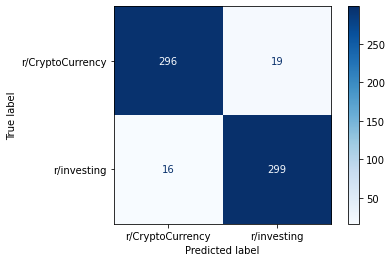

In [62]:
# Create and fit final selected model

pipe = Pipeline([
    ('tvec', TfidfVectorizer(
        max_features = 2000,
        ngram_range = (1, 1)
        )
    ),
    ('logit', LogisticRegression(
        C = 10,
        penalty = 'l2'
        )
    )
])

pipe.fit(X_train, y_train)

# Confusion matrix
y_pred = pipe.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

plot_confusion_matrix(pipe, 
                      X_test, y_test, 
                      cmap='Blues', 
                      values_format='d', 
                      display_labels=['r/CryptoCurrency', 'r/investing']
                     );
# Print results
print(f'Test score (aka Accuracy): {pipe.score(X_test, y_test):.3f}')
print(f'Sensitivity: {tp/(tp+fn):.3f}, Specificity: {tn/(tn+fp):.3f}, Precision: {tp/(tp+fp):.3f}')

The model has an accuracy of 94%. Out of 630 posts in the test set, it got 595 correct, i.e. assigning reddit posts to r\CryptoCurrency and r\investing correctly. Only 5% of posts are misclassified.

It also seems to be equally good in predicting r\CryptoCurrency posts [296 / (296+19)] = 93.9% = specificity, as it is in predicting r\investing posts [299/(299+16)] = 94.9% = sensitivity (I had arbitrarily set r\investing as "1" and r\CryptoCurrency as "0" earlier on).

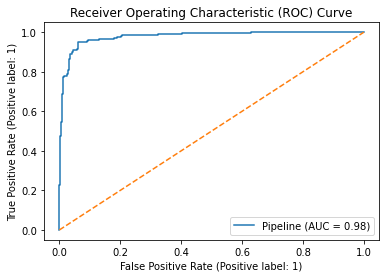

In [37]:
# ROC curve
plot_roc_curve(pipe, X_test, y_test)

# add worst case scenario line
plt.plot([0,1], [0,1], label = "baseline", linestyle = "--")

# add title
plt.title('Receiver Operating Characteristic (ROC) Curve');

I have an ROC score of 0.98 which is a very respectable score (perfect score is 1.0, worst is 0.5). The ROC curve plots the highest true positive rate (r\investing) together with the lowest false positive rate (predicting r\investing when it actually belongs to r\CryptoCurrency).

## Feature Importance

Let's look at what are the word features that give us a decent prediction capability.

In [38]:
# Obtain coefficients from logit model
coef = pipe.named_steps['logit'].coef_.flatten()

In [39]:
# Obtain feature names from TF-IDF vectorizer
features = pipe.named_steps['tvec'].get_feature_names()

In [40]:
# Check length as defined during model fitting
len(coef), len(features)

(2000, 2000)

In [41]:
# Create dataframe of features and their coefficients
df_coef = pd.DataFrame(zip(features, coef), 
                       columns = ["Features", "Coefficient"]
                      ).sort_values('Coefficient', 
                                    ascending = False)

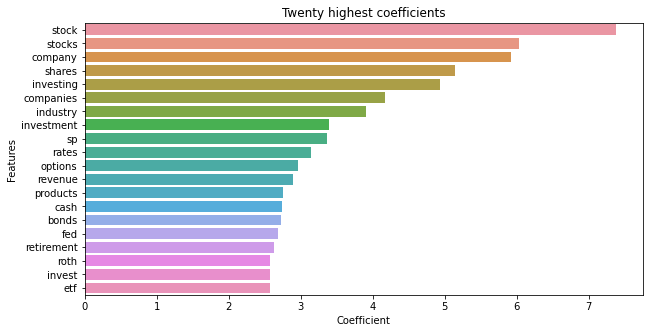

In [42]:
# Plot 20 highest coefficients
plt.figure(figsize=(10,5))
ax = sns.barplot(x = 'Coefficient', y = 'Features', data = df_coef.head(20))
ax.set_title(f"Twenty highest coefficients")
ax.set_xlabel("Coefficient")
ax.set_ylabel("Features");

**Observations**

We interpret these coeffcients such that the odds of landing a "1" which is r/investing is higher for positive coefficients, and the odds of landing a "0" which is r/CryptoCurrency is higher for negative coefficients.

From our results, there are relatively strong correlations around the terms 'stock', 'company', 'shares' and 'investing' for the r/investing subreddit. This is unsurprising as potential investers are often interested in knowing what are the best performing stocks, companies to look out for and any shares that are worth holding and/or buying.

We also see a wide range of traditional investments being frequently discuessed in the r/investing. From the stock market index tracking the performance of 500 large companies listed on stock exchanges in the United States(i.e. the S&P 500, as seen by 'sp' in the graph above), to the volatile options trading, and even comparatively stable fixed income investment like bonds, this focus words clearly shows us the trend in the r/investing subreddit.

Referenced URLs:
- https://www.investopedia.com/terms/s/sp500.asp
- https://www.investopedia.com/articles/active-trading/040915/guide-option-trading-strategies-beginners.asp
- https://www.investopedia.com/terms/b/bond.asp

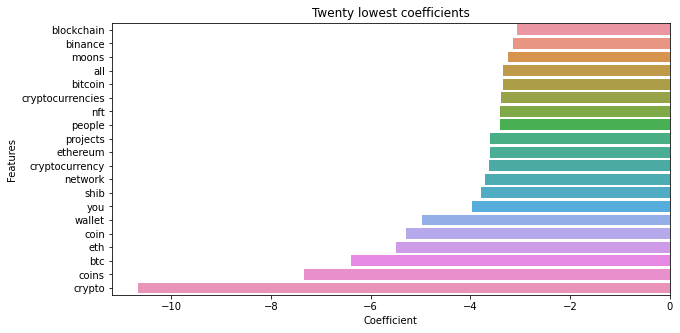

In [43]:
# Plot 20 lowest coefficients
plt.figure(figsize=(10,5))
ax = sns.barplot(x = 'Coefficient', y = 'Features', data = df_coef.tail(20))
ax.set_title(f"Twenty lowest coefficients")
ax.set_xlabel("Coefficient")
ax.set_ylabel("Features");

**Observations**

From our results, there are relatively strong correlation around the terms 'coins', 'btc' and 'eth'. It is unsurprising that the people interested in CryptoCurrency would be interested in knowing more about popular blockchains like Ethereum (where Eth is the currency of it), digital currencies like bitcoins & Shiba Inu (as acronym as 'btc' & 'shib' respectively), to undertanding the different networks of blockchain technology. 

This shows us the hot trends in the r/CryptoCurrency subreddit.

Referenced URLs:
https://www.investopedia.com/terms/e/ethereum.asp
https://www.coindesk.com/price/bitcoin/
https://www.investopedia.com/shiba-inu-shib-5207903#what-is-shiba-inu
https://searchcio.techtarget.com/feature/What-are-the-4-different-types-of-blockchain-technology

### Interpreting Coefficients

As the features are regressed on log(odds), the way to convert the coeffficients is to take its nature exponential, i.e. np.exp(). Meaning: For every one unit increase in a particular feature, we expect the odds of a post appearing un r\investing to increase by a factor of np.exp(feature's coefficient value).

In [49]:
df_coef.head(10)

,Features,Coefficient
1670,stock,7.378867
1671,stocks,6.037970
334,company,5.918159
1568,shares,5.138268
905,investing,4.931897
333,companies,4.165361
877,industry,3.914030
906,investment,3.391314
1633,sp,3.362562
1404,rates,3.141417


In [51]:
#interpret coefficient for stocks:
np.exp(7.378867)

1601.773929492228

An increase in discussion of stocks suggest that it is 1601 times as likely to appear in the r/investing subbreddit, holding all else constant.

In [50]:
df_coef.tail(10)

,Features,Coefficient
409,cryptocurrency,-3.628470
1149,network,-3.710573
1572,shib,-3.782672
1992,you,-3.974140
1903,wallet,-4.968490
315,coin,-5.293080
565,eth,-5.496339
223,btc,-6.384673
318,coins,-7.329514
407,crypto,-10.656360


In [52]:
#interpret coefficient for coins:
np.exp(-7.329514)

0.0006558922733235126

An increase in discussion of coins suggest that it is seemingly impossible for it to appear in the r/investing subbreddit, holding all else constant.

## Misclassification Analysis

Misclassification is often produced due to the lack of contextual knowledge. Since the algorithms applied has no knowledge on natural human language patterns, it takes numerical weights of word distributions to predict the results instead. Such are the limitations of the modeling we have applied onto our datasets.

We create a dataframe of the test set and its corresponding predicted values. The dataframe was made by merging 3 series/numpy arrays: X_test, y_test and predicted y (y_preds).

In [63]:
# Create DataFrame of predicated values and actual values
results = pd.DataFrame(
    zip(y_test, pipe.predict(X_test)),
    columns = ['actual', 'predicted']
)

In [64]:
# Check
results['title_n_text'] = X_test.reset_index(drop = True)

In [65]:
# Find all index values where predicted and true results 
# aren't the same, then save in an array.
results = results[results.actual != results.predicted]

In [66]:
results[:1]

,actual,predicted,title_n_text
82,0,1,"['Can Wall Street funds manipulate Bitcoin price for Bitcoin Futures ETF ', ' I am new to all these financial instruments so this question popped into my mind if Wall Street has enough wallets and bitcoins to create an artificial trade volume of one day s worth of trades on an exchange could they create a fake valuation for the Bitcoin that helps their future trades And if all bitcoin wallets are anonymous how can a user know if the trades are real or just market manipulation Are there any laws that hold these funds accountable if they engage in activities that prey on the retail investors ']"


In [58]:
results['word_count'] = results['title_n_text'].map(lambda x: len(x.split()))

### False Positive Posts

False positives are datapoints which we had predicted to originate from r/CryptoCurrency but is actually from r/investing. We quote some text below and explain why they may have been misclassified:

In [59]:
# Describe and sample false positive posts 
pd.set_option('display.max_colwidth', None)
display(results.loc[results['predicted'] == 1].describe())
display(results.loc[results['predicted'] == 1].sample(3))

,actual,predicted,word_count
count,19.0,19.0,19.000000
mean,0.0,1.0,145.789474
std,0.0,0.0,76.010656
min,0.0,1.0,34.000000
25%,0.0,1.0,97.500000
50%,0.0,1.0,128.000000
75%,0.0,1.0,204.000000
max,0.0,1.0,316.000000


,actual,predicted,title_n_text,word_count
514,0,1,"['Seems like great branding', 'Does anyone know where to buy FreedomCoin Seems like great meme potential yet as far as I can tell most of these aren t traded anywhere lol Any ideas ']",34
249,0,1,"['Newbie where TF do I start ', 'Trying to get into crypto to secure the bag for my family but I have no idea where to start to get solid info Can someone point me in the right direction ']",40
336,0,1,"['First investments for a Broke Ass Dad', 'Hi I recently was able to save up just over grand which I want to invest with I m a single dad so I don t have a lot of disposable income but my time into he public service has given me a pension for retirment and the health coverage I need so I am not totally risk adverse I want to invest in crypto well and utilize it for purchases somewhat Everything you read is great and a wonderful investment but I m looking for some solid advice for a beginner not sponsored content My intention is to build on this money slowly add more of my own and from buying and selling stuff I do not the side The goal is to turn this bucks into money to start a seperate consulting buisness In short this would be my main investment currently for the next few years likely with intention of pulling it out for other investments Likely at that point my crypto accounts would act as more of a supplementary invesment rather than the main one Locally real estate is on the verge of collapse and God knows what else so crypto seems to be the best bet currently b Any advice appriciated ']",214


**Text 1:**
> 'Seems like great branding', 'Does anyone know where to buy FreedomCoin Seems like great meme potential yet as far as I can tell most of these aren t traded anywhere lol Any ideas' 

The above post used focus words like 'FreedomCoin' which is a blockchained based currency. The user might have posted a CryptoCurrency question in the r/investing subreddit instead to reach a wider audience.

Referenced URL:
https://currencyworks.io/project/freedomcoin/

**Text 2:**
> 'Newbie where TF do I start ', 'Trying to get into crypto to secure the bag for my family but I have no idea where to start to get solid info Can someone point me in the right direction'

The above post used focus words like 'crypto'. However, we observe that the user is a newly interested person in CryptoCurrency and therefore, could be unaware that there is another separate subreddit which focuses solely on CrypoCurrency instead. Hence, the post is posted in the nonoptimal r/investing subreddit.

**Text 3:**
> 'First investments for a Broke Ass Dad', 'Hi I recently was able to save up just over grand which I want to invest with I m a single dad so I don t have a lot of disposable income but my time into he public service has given me a pension for retirment and the health coverage I need so I am not totally risk adverse I want to invest in crypto well and utilize it for purchases somewhat Everything you read is great and a wonderful investment but I m looking for some solid advice for a beginner not sponsored content My intention is to build on this money slowly add more of my own and from buying and selling stuff I do not the side The goal is to turn this bucks into money to start a seperate consulting buisness In short this would be my main investment currently for the next few years likely with intention of pulling it out for other investments Likely at that point my crypto accounts would act as more of a supplementary invesment rather than the main one Locally real estate is on the verge of collapse and God knows what else so crypto seems to be the best bet currently b Any advice appriciated '

The above post used focus words like 'investments', and 'crypto'. Likewise, this user appears to be interested in CrypoCurrency. However, he too is new to investing and appears to be open for general investment advices. Hence, this post is correctly posted, since the user is open to accepting general investing advices as well. The lack of contextual understanding in NLP models cause misclassifications due to our model's sole reliance onto numerical analysis.

### False Negative Posts

In [77]:
# Describe and sample false negative posts 
display(results.loc[results['predicted'] == 0].describe())
display(results.loc[results['predicted'] == 0].sample(3))

,actual,predicted
count,16.0,16.0
mean,1.0,0.0
std,0.0,0.0
min,1.0,0.0
25%,1.0,0.0
50%,1.0,0.0
75%,1.0,0.0
max,1.0,0.0


,actual,predicted,title_n_text
142,1,0,"['How are you preparing for ', 'What stocks or funds are you loading up on going into I m still heavy in tech but I m wondering how inflation will impact that sector We also have supply chain issues looming crypto regulation and an increasingly aggressive China I ve had some interesting winners so far in like GNRC ODFL and good old VOO Like many of you I was clobbered by my early losses in green energy and have finally clawed my way back into the green I made some changes around July to load up on AAPL MSFT and GOOG And TSLA is finally making me some money again Just curious to hear what you all are doing ']"
112,1,0,"['THE MOST FLEXSIBLE WAY TO EARN CRYPTO', 'THE MOST FLEXSIBLE WAY TO EARN CRYPTOThere is no minimum deposit You can start with as little as you want We ve created a feature that allows everyone to be a part of the network SETTING UP A VAULT IN DIVI WALLET Download Divi Wallet if you haven t already Back up your wallet Purchase Divi from an exchange or send some from another wallet Select the Earn tab and select staking vault From here you will be able to add funds to the vault HWO DOES THE PRICING WORK We have decided upon a pricing structure that we think will feel fair to our community whilst making it easy to begin staking We have decided upon subscription pricing at a flat rate per month so as the DIVI coin price increases you will benefit even more If you have between and DIVI in a vault the base cost will be USD per month From here k k every DIVI increases the cost by USD per month up to USD per month SO WHERE TO FROM HERE we re extending access to our community members with under DIVI Up until now those people have not had a dedicated easy to use way to put their Divi to work Now they can ']"
510,1,0,"['Investors or Reddit that become wealthy off the stock market what advice would you give someone that has just turned ', 'My goal is to become a millionaire by I can achieve any thing I want and no body is going to stop me I ve achieved so much in my life so far that many people have not I m motivated and ready to attack this for the next years I ll sacrifice my social life for this i want it The only things keeping me sane is being Christian and working out I m ready to be a workaholic and live life to the fullest I m even considering deleting my tiktok of k followers to dicots on this I plan stay in peak physical condition and achieve this goal by I m hungry for it man ']"


**Text 1:**
> 'How are you preparing for ', 'What stocks or funds are you loading up on going into I m still heavy in tech but I m wondering how inflation will impact that sector We also have supply chain issues looming crypto regulation and an increasingly aggressive China I ve had some interesting winners so far in like GNRC ODFL and good old VOO Like many of you I was clobbered by my early losses in green energy and have finally clawed my way back into the green I made some changes around July to load up on AAPL MSFT and GOOG And TSLA is finally making me some money again Just curious to hear what you all are doing '

The above post used focus words like 'stocks', 'funds', and 'crypto'. The user has correctly post a dicussion in the r/investing subreddit. However, he makes an additional statement regarding crypto regulation which sounds like an for-your-information kind of statement. 

**Text 2:**
> 'THE MOST FLEXSIBLE WAY TO EARN CRYPTO', 'THE MOST FLEXSIBLE WAY TO EARN CRYPTOThere is no minimum deposit You can start with as little as you want We ve created a feature that allows everyone to be a part of the network SETTING UP A VAULT IN DIVI WALLET Download Divi Wallet if you haven t already Back up your wallet Purchase Divi from an exchange or send some from another wallet Select the Earn tab and select staking vault From here you will be able to add funds to the vault HWO DOES THE PRICING WORK We have decided upon a pricing structure that we think will feel fair to our community whilst making it easy to begin staking We have decided upon subscription pricing at a flat rate per month so as the DIVI coin price increases you will benefit even more If you have between and DIVI in a vault the base cost will be USD per month From here k k every DIVI increases the cost by USD per month up to USD per month SO WHERE TO FROM HERE we re extending access to our community members with under DIVI Up until now those people have not had a dedicated easy to use way to put their Divi to work Now they can '

The above post used focus word like 'crypto'. This post appears to be wrongly classified.

**Text 3:**:
> 'Investors or Reddit that become wealthy off the stock market what advice would you give someone that has just turned ', 'My goal is to become a millionaire by I can achieve any thing I want and no body is going to stop me I ve achieved so much in my life so far that many people have not I m motivated and ready to attack this for the next years I ll sacrifice my social life for this i want it The only things keeping me sane is being Christian and working out I m ready to be a workaholic and live life to the fullest I m even considering deleting my tiktok of k followers to dicots on this I plan stay in peak physical condition and achieve this goal by I m hungry for it man '

The above post used focus word like 'stock'. It is correctly posted in the r/investing subreddit.

**Observations**

It appears that the focus word 'crypto' is a call for concern. Newly interested users of CryptoCurrency may find themselves inclined to discuss about CryptoCurrency in the r/investing subreddit, due to the lack of knowledge and/or awareness of the r/CryptoCurrency subreddit.

# Conclusions & Recommendations 

### Conclusion
Our chosen model of the Logistic Regression on the TF-IDF Vectoriser appears to perform very well at 94% accuracy. 

Even though there may be some overlapping words (for example, 'buy', 'money' and 'market) in the unigram, the model performs better with the inclusion of unigram. 

The subreddits r/investing and r/CryptoCurrency may seem similar, but the results from the model and the top feature words show us that the discussions on the subreddits differ greatly and we need not worry that we are unable to accurately filter the information from the subreddits to the correct trading desks. Additionally, we can anticipate with expectant hearts for the new leads & hot trends for both traditional securities and CryptoCurrency to be identified accurately. 

### Recommendations

1. Be cautious of the word 'crypto' being used loosely. 
    - People new to investing may be unaware of the difference between traditional securities and CryptoCurrency.
    
2. Remain up-to-date in knowledge.
    - Especially so for CryptoCurrency where there are new coins being discussed frequently, frequent training and knowledge can be shared among the employees of the trading company so that common acronyms that are frquently used would be caught on by the employees of the trading desk. This will prevent any real data that are not wrongly and mistakenly identified as a stopword to be excluded. 
    
3. Expand the data collection beyond the subreddits.
    - This subreddits may be a good starting point to identify the general sentiments and areas of interest within traditional securities and CryptoCurrency. However, this limits us to the users who engage in the subreddits only. There is a concern that the results from the subreddits are contributed by the same small group of people only. To ensure there is no bias, perhaps the collection of data from other social media platforms like 'Twitter' and 'YouTube' would allow us to garner a wider range of data from a wider audience as well.
    
4. Obtain greater computing power or more time to process a greater number of hyperparameters.
    - Due to time and technological constraints, our model is ran against a few hyperparameters only. If the trading company has the time & capacity to allow for a more in-depth research to be done for the model and is able to provide greater technological support (like greater computing power), perhaps more hyperparameters can be included. For example, running against a wider rnage of maximum features and ngrams as well.